# Classification of Ocean Microbes

***

## Project Description

You are provided a dataset that represents a 21 minute sample from the vessel in a file seaflow_21min.csv. This sample has been pre-processed to remove the calibration "beads" that are passed through the system for monitoring, as well as some other particle types.

## Data Dictionary

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
|file_id |The data arrives in files, where each file represents a three-minute window; this field represents which file the data came from. The number is ordered by time, but is otherwise not significant |
|time |This is an integer representing the time the particle passed through the instrument. Many particles may arrive at the same time; time is not a key for this relation	|
|cell_id |A unique identifier for each cell WITHIN a file. (file_id, cell_id) is a key for this relation |
|d1, d2 |Intensity of light at the two main sensors, oriented perpendicularly. These sensors are primarily used to determine whether the particles are properly centered in the stream. Used primarily in preprocesssing; they are unlikely to be useful for classification	|
| fsc_small, fsc_perp, fsc_big |Forward scatter small, perpendicular, and big. These values help distingish different sizes of particles	|
|pe |A measurement of phycoerythrin fluorescence, which is related to the wavelength associated with an orange color in microorganisms	|
|hl_small, chl_big |Measurements related to the wavelength of light corresponding to chlorophyll	|
|pop |This is the class label assigned by the clustering mechanism used in the production system. It can be considered "ground truth" for the purposes of the assignment, but note that there are particles that cannot be unambiguously classified, so you should not aim for 100% accuracy. The values in this column are crypto, nano, pico, synecho, and ultra	|

## Business Task

You will work with the dataset in R, using and evaluating a few different classification methods. You will not turn in the code itself; you will answer questions about the data and methods that (hopefully) demonstrate that you have written correct code. As usual, we will tend not to provide specific syntax; you will look up the appropriate documentation and experiment with the language to elicit the correct answer. That said, learning R as a programming language is not a goal of this assignment (or this course) -- there are plenty of courses that aim to teach the use of R. The goal of this assignment is to use R to experiment with a real dataset -- including its idiosyncrasies -- and to consider the strengths and weaknesses of a few popular methods for supervised learning.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

import sklearn

import shap
import eli5
from IPython.display import display
import statsmodels.api as sm

import datetime
from datetime import datetime, timedelta


import scipy.stats

#from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor


%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.tree import export_graphviz, plot_tree, export_text
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


# Use Feature-Engine library

#import feature_engine.missing_data_imputers as mdi
#from feature_engine.outlier_removers import Winsorizer
#from feature_engine import categorical_encoders as ce


#from pycaret.classification import *
#from pycaret.clustering import *
#from pycaret.regression import *

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)


random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


## Exploratory Data Analysis

In [2]:
df = pd.read_csv("seaflow_21min.csv")

In [3]:
df

,file_id,time,cell_id,d1,d2,fsc_small,fsc_perp,fsc_big,pe,chl_small,chl_big,pop
0,203,12,1,25344,27968,34677,14944,32400,2216,28237,5072,pico
1,203,12,4,12960,22144,37275,20440,32400,1795,36755,14224,ultra
2,203,12,6,21424,23008,31725,11253,32384,1901,26640,0,pico
3,203,12,9,7712,14528,28744,10219,32416,1248,35392,10704,ultra
4,203,12,11,30368,21440,28861,6101,32400,12989,23421,5920,synecho
...,...,...,...,...,...,...,...,...,...,...,...,...
72338,209,643,31305,20608,29168,31563,15667,32400,8333,18491,0,synecho
72339,209,643,31307,22128,19600,26848,9317,32400,22011,15384,7536,synecho
72340,209,643,31314,21024,24800,31059,16299,32400,9928,11496,0,synecho
72341,209,643,31315,24672,18912,36008,18301,32400,1443,29435,4720,pico


### Step 1: Read and summarize the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72343 entries, 0 to 72342
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_id    72343 non-null  int64 
 1   time       72343 non-null  int64 
 2   cell_id    72343 non-null  int64 
 3   d1         72343 non-null  int64 
 4   d2         72343 non-null  int64 
 5   fsc_small  72343 non-null  int64 
 6   fsc_perp   72343 non-null  int64 
 7   fsc_big    72343 non-null  int64 
 8   pe         72343 non-null  int64 
 9   chl_small  72343 non-null  int64 
 10  chl_big    72343 non-null  int64 
 11  pop        72343 non-null  object
dtypes: int64(11), object(1)
memory usage: 6.6+ MB


In [5]:
df.describe(include='all')

,file_id,time,cell_id,d1,d2,fsc_small,fsc_perp,fsc_big,pe,chl_small,chl_big,pop
count,72343.00,72343.00,72343.00,72343.00,72343.00,72343.00,72343.00,72343.00,72343.00,72343.00,72343.00,72343
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pico
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20860
mean,206.15,341.45,15008.25,17038.62,17436.74,34918.97,17645.61,32405.27,5325.04,30163.64,8328.11,NaN
std,2.04,185.58,8695.68,9321.15,9607.48,7463.45,7360.70,9.48,6523.17,10439.45,6610.42,NaN
min,203.00,12.00,0.00,1328.00,32.00,10005.00,0.00,32384.00,0.00,3485.00,0.00,NaN
25%,204.00,174.00,7485.50,7296.00,9584.00,31341.00,13496.00,32400.00,1635.00,22525.00,2800.00,NaN
50%,206.00,362.00,14995.00,17728.00,18512.00,35483.00,18069.00,32400.00,2421.00,30512.00,7744.00,NaN
75%,208.00,503.00,22401.00,24512.00,24656.00,39184.00,22243.00,32416.00,5854.50,38299.00,12880.00,NaN


In [6]:
df.shape

(72343, 12)

In [7]:
df.columns

Index(['file_id', 'time', 'cell_id', 'd1', 'd2', 'fsc_small', 'fsc_perp', 'fsc_big', 'pe', 'chl_small', 'chl_big', 'pop'], dtype='object')

In [8]:
# How many particles labeled "synecho" are in the file provided?
df["pop"].value_counts()

pico       20860
ultra      20537
synecho    18146
nano       12698
crypto       102
Name: pop, dtype: int64

In [9]:
# What is the 3rd Quantile of the field fsc_small? (the summary function computes this on your behalf)

df.fsc_small.describe()

count   72343.00
mean    34918.97
std      7463.45
min     10005.00
25%     31341.00
50%     35483.00
75%     39184.00
max     65424.00
Name: fsc_small, dtype: float64

### Step 2: Split the data into test and training sets

## Data Visualization

### Univariate Data Exploration

In [10]:
# df.hist(bins=50, figsize=(20,10))
# plt.suptitle('Histogram Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
# plt.tight_layout()
# plt.show()

In [11]:
# df.boxplot(figsize=(20,10))
# plt.suptitle('BoxPlots Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
# plt.tight_layout()
# plt.show()

### Correlation

In [12]:
#df.corr()

In [13]:
# plt.figure(figsize=(16,9))
# sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2, cbar=False)
# plt.title("", fontsize=20)
# plt.show()

### Drop unwanted features

In [14]:
df.columns

Index(['file_id', 'time', 'cell_id', 'd1', 'd2', 'fsc_small', 'fsc_perp', 'fsc_big', 'pe', 'chl_small', 'chl_big', 'pop'], dtype='object')

In [15]:
df.drop(['file_id', 'cell_id', 'd1', 'd2'], axis=1, inplace=True)

In [16]:
df.head()

,time,fsc_small,fsc_perp,fsc_big,pe,chl_small,chl_big,pop
0,12,34677,14944,32400,2216,28237,5072,pico
1,12,37275,20440,32400,1795,36755,14224,ultra
2,12,31725,11253,32384,1901,26640,0,pico
3,12,28744,10219,32416,1248,35392,10704,ultra
4,12,28861,6101,32400,12989,23421,5920,synecho


In [17]:
encoder = LabelEncoder()

In [18]:
df["pop"] = encoder.fit_transform(df["pop"])

In [19]:
df.head()

,time,fsc_small,fsc_perp,fsc_big,pe,chl_small,chl_big,pop
0,12,34677,14944,32400,2216,28237,5072,2
1,12,37275,20440,32400,1795,36755,14224,4
2,12,31725,11253,32384,1901,26640,0,2
3,12,28744,10219,32416,1248,35392,10704,4
4,12,28861,6101,32400,12989,23421,5920,3


### Step 2: Split the data into test and training sets

In [20]:
df.shape

(72343, 8)

In [21]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]

In [22]:
X.values, y.values

(array([[   12, 34677, 14944, ...,  2216, 28237,  5072],
        [   12, 37275, 20440, ...,  1795, 36755, 14224],
        [   12, 31725, 11253, ...,  1901, 26640,     0],
        ...,
        [  643, 31059, 16299, ...,  9928, 11496,     0],
        [  643, 36008, 18301, ...,  1443, 29435,  4720],
        [  643, 37096, 22192, ..., 17995, 21288,  5024]], dtype=int64),
 array([2, 4, 2, ..., 3, 2, 3]))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36171, 7), (36172, 7), (36171,), (36172,))

## Feature Scaling

In [25]:
X_train

,time,fsc_small,fsc_perp,fsc_big,pe,chl_small,chl_big
27408,274,42835,25984,32400,1667,42509,15680
5261,57,21067,840,32400,2819,32819,11024
22608,222,32072,14349,32400,549,21683,3328
11661,114,31848,12048,32400,2645,29107,10432
28182,282,13755,248,32400,2403,19387,0
...,...,...,...,...,...,...,...
21243,206,33453,19840,32400,16339,14984,3360
45891,440,24989,10355,32400,7336,12349,0
42613,414,30549,12923,32400,19760,9771,0
43567,422,37179,18315,32416,1507,37909,7920


In [26]:
# Question 3 
# What is the mean of the variable "time" for your training set?  
X_train.time.mean()

340.720217854082

### Step 3: Plot the data

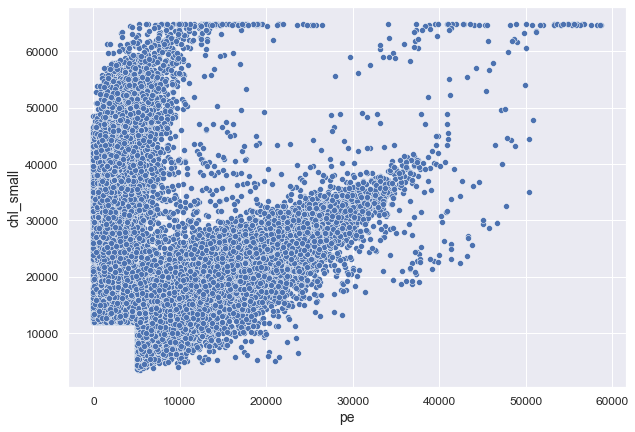

In [27]:
# Plot pe against chl_small and color by pop
plt.figure(figsize=(10,7))
sns.scatterplot(x=df.pe, y=df.chl_small, data=df, palette='viridis')
plt.show()

In [28]:
df["pop"].value_counts()

2    20860
4    20537
3    18146
1    12698
0      102
Name: pop, dtype: int64

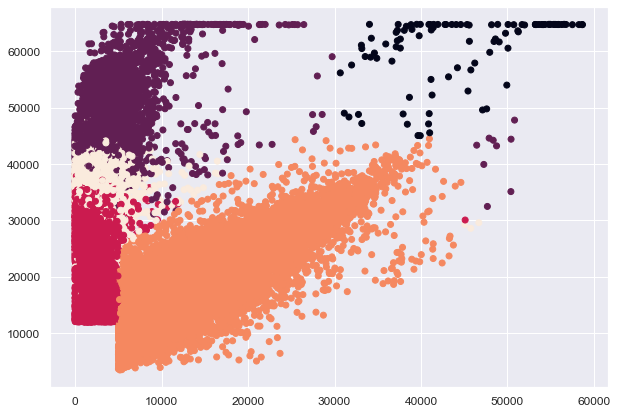

In [29]:
plt.figure(figsize=(10,7))
plt.scatter(x=df.pe, y=df.chl_small,c=df["pop"])
plt.show()

### Step 4: Train a decision tree.

In [30]:
X.drop(["time"], axis=1, inplace=True)

In [31]:
X.head()

,fsc_small,fsc_perp,fsc_big,pe,chl_small,chl_big
0,34677,14944,32400,2216,28237,5072
1,37275,20440,32400,1795,36755,14224
2,31725,11253,32384,1901,26640,0
3,28744,10219,32416,1248,35392,10704
4,28861,6101,32400,12989,23421,5920


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.5, random_state=0)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36171, 6), (36172, 6), (36171,), (36172,))

In [34]:
scaler = StandardScaler()

In [35]:
X_train_scaled = scaler.fit_transform(X_train)

In [36]:
X_test_scaled = scaler.transform(X_test)

In [37]:
X_train_scaled

array([[ 1.05829152,  1.13090324, -0.55468593, -0.56040707,  1.17623479,
         1.10001765],
       [-1.83981334, -2.27205146, -0.55468593, -0.38496247,  0.2512981 ,
         0.40151876],
       [-0.37465145, -0.44376181, -0.55468593, -0.73067362, -0.81166319,
        -0.75304468],
       ...,
       [-0.57741761, -0.63675471, -0.55468593,  2.19507829, -1.94869579,
        -1.25231536],
       [ 0.3052742 ,  0.09299123,  1.13444901, -0.58477437,  0.73715236,
        -0.06414716],
       [ 0.46610251,  0.37625499, -0.55468593, -0.44877435,  0.25530711,
         0.90078944]])

In [38]:
X_test_scaled

array([[-2.24707643, -1.72596006, -0.55468593, -0.48730515, -0.56071804,
        -1.25231536],
       [ 0.24163518,  0.0659235 ,  1.13444901, -0.64081918,  1.44350236,
         1.73370735],
       [-1.35200297, -1.22899658, -0.55468593, -0.44679451, -1.13142975,
         0.46152726],
       ...,
       [ 0.13619145, -0.11894908, -0.55468593,  0.59460321, -1.05812207,
        -1.20430856],
       [-1.12620428, -1.41738797, -0.55468593, -0.45897816, -1.1543384 ,
        -0.55621682],
       [ 0.95883891,  1.1742116 ,  1.13444901,  1.34633458, -0.43290687,
         0.62475036]])

### Model Training

In [39]:
dt_model = DecisionTreeClassifier()

In [40]:
dt_model.fit(X_train_scaled,y_train)

DecisionTreeClassifier()

In [41]:
text_representation = export_text(dt_model)
print(text_representation)

|--- feature_3 <= -0.05
|   |--- feature_4 <= 0.22
|   |   |--- feature_4 <= 0.02
|   |   |   |--- feature_0 <= -0.69
|   |   |   |   |--- feature_4 <= -0.42
|   |   |   |   |   |--- feature_3 <= -0.05
|   |   |   |   |   |   |--- feature_4 <= -0.74
|   |   |   |   |   |   |   |--- feature_5 <= 0.25
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- feature_5 >  0.25
|   |   |   |   |   |   |   |   |--- feature_5 <= 0.27
|   |   |   |   |   |   |   |   |   |--- feature_1 <= -1.37
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- feature_1 >  -1.37
|   |   |   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |   |   |--- feature_5 >  0.27
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- feature_4 >  -0.74
|   |   |   |   |   |   |   |--- feature_0 <= -1.22
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- feature_0 >  -1.22
|   |   |   |   

In [42]:
# fig = plt.figure(figsize=(25,20))
# _ = plot_tree(decision_tree=dt_model, feature_names=X.columns)

### Step 5: Evaluate the decision tree on the test data.

In [43]:
y_pred = dt_model.predict(X_test_scaled)

In [44]:
y_pred

array([2, 1, 2, ..., 3, 2, 3])

### Model Evaluation

In [45]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[  46,    1,    0,    3,    0],
       [   1, 5461,    0,    3,  850],
       [   0,    1, 8952,    5, 1484],
       [   0,    3,    1, 9069,    4],
       [   0,  899, 1371,    5, 8013]], dtype=int64)

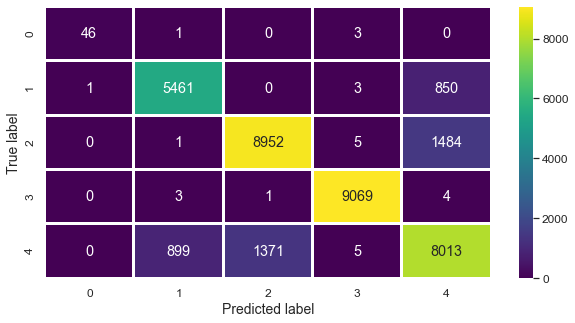

In [46]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        50
           1       0.86      0.86      0.86      6315
           2       0.87      0.86      0.86     10442
           3       1.00      1.00      1.00      9077
           4       0.77      0.78      0.78     10288

    accuracy                           0.87     36172
   macro avg       0.90      0.88      0.89     36172
weighted avg       0.87      0.87      0.87     36172



### Step 6: Build and evaluate a random forest

In [48]:
rf_model = RandomForestClassifier()

In [49]:
rf_model.fit(X_train_scaled,y_train)

RandomForestClassifier()

In [50]:
y_pred = rf_model.predict(X_test_scaled)

In [51]:
y_pred

array([2, 1, 2, ..., 3, 2, 3])

### Model Evaluation

In [52]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[   49,     0,     0,     1,     0],
       [    1,  5554,     0,     3,   757],
       [    0,     0, 10130,     4,   308],
       [    1,     2,     0,  9074,     0],
       [    0,   367,  1367,     7,  8547]], dtype=int64)

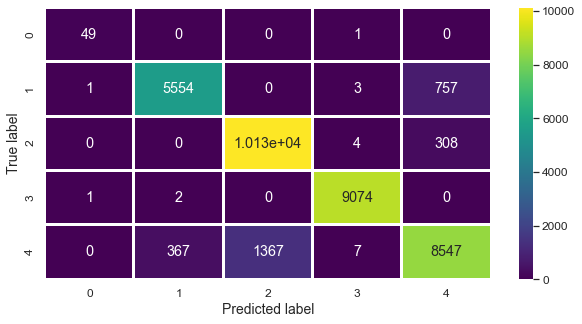

In [53]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       0.94      0.88      0.91      6315
           2       0.88      0.97      0.92     10442
           3       1.00      1.00      1.00      9077
           4       0.89      0.83      0.86     10288

    accuracy                           0.92     36172
   macro avg       0.93      0.93      0.93     36172
weighted avg       0.92      0.92      0.92     36172



### Plot Feature Importances

In [55]:
rf_model.feature_importances_

array([0.09822182, 0.07773978, 0.00758166, 0.32495417, 0.31206561,
       0.17943696])

In [56]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

In [57]:
feat_importances

fsc_small   0.10
fsc_perp    0.08
fsc_big     0.01
pe          0.32
chl_small   0.31
chl_big     0.18
dtype: float64

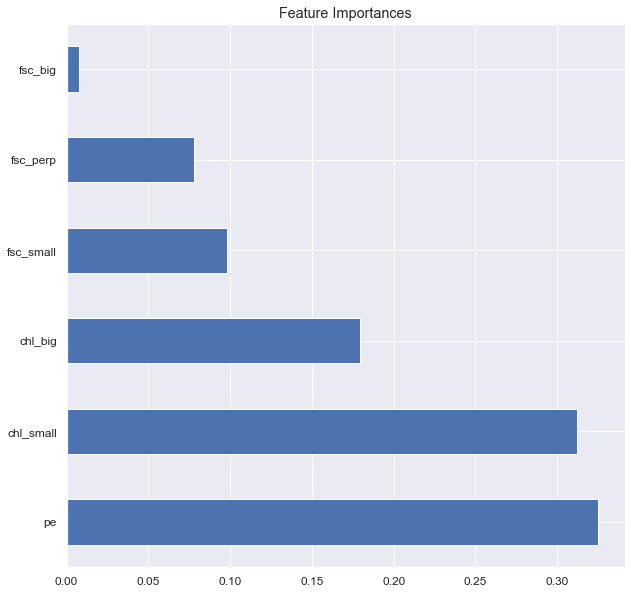

In [58]:
feat_importances.nlargest(10).plot(kind='barh', figsize=(10,10))
plt.title('Feature Importances')
plt.show()

### Step 7: Train a support vector machine model and compare results

In [59]:
svm_model = SVC()

In [60]:
svm_model.fit(X_train_scaled,y_train)

SVC()

In [61]:
y_pred = svm_model.predict(X_test_scaled)

In [62]:
y_pred

array([2, 1, 2, ..., 3, 2, 3])

### Model Evaluation

In [63]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[   48,     1,     0,     1,     0],
       [    2,  5609,     0,     6,   698],
       [    0,     0, 10095,    56,   291],
       [    1,     4,    26,  9042,     4],
       [    0,   399,  1342,     4,  8543]], dtype=int64)

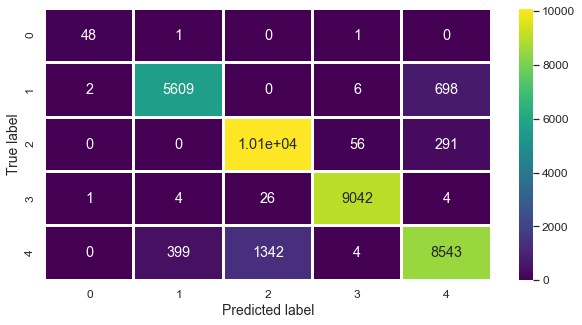

In [64]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [65]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        50
           1       0.93      0.89      0.91      6315
           2       0.88      0.97      0.92     10442
           3       0.99      1.00      0.99      9077
           4       0.90      0.83      0.86     10288

    accuracy                           0.92     36172
   macro avg       0.93      0.93      0.93     36172
weighted avg       0.92      0.92      0.92     36172



#### Python code done by Dennis Lam